In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [5]:
df = pd.read_csv("../data/processed/311_weather_features.csv")
df["date"] = pd.to_datetime(df["date"])

print(f"Loaded dataset: {df.shape}")
df.head()

Loaded dataset: (731, 57)


,date,total_complaints,complaints_abandoned_vehicle,complaints_blocked_driveway,complaints_derelict_vehicles,complaints_dirty_condition,complaints_heat_hot_water,complaints_illegal_parking,complaints_noise,complaints_noise___commercial,...,complaints_rolling_7d,season_spring,season_summer,season_winter,temp_bin_cold,temp_bin_mild,temp_bin_hot,precip_intensity_light,precip_intensity_moderate,precip_intensity_heavy
0,2023-01-01,6209,71,489,58,58,466,1024,39,194,...,6209.0,False,False,True,True,False,False,True,False,False
1,2023-01-02,6680,165,371,135,117,681,1092,57,81,...,6444.5,False,False,True,True,False,False,True,False,False
2,2023-01-03,8255,167,433,133,148,688,1234,158,73,...,7048.0,False,False,True,True,False,False,False,True,False
3,2023-01-04,8462,199,439,157,160,518,1358,143,64,...,7401.5,False,False,True,False,True,False,True,False,False
4,2023-01-05,8414,219,455,170,149,809,1278,163,103,...,7604.0,False,False,True,True,False,False,False,False,False


In [6]:
# Target feature
target = "total_complaints"

# Features to exclude (date, target, and complaint-related columns we're predicting)
exclude_cols = ['date', target, 'complaints_prev_day', 'complaints_rolling_7d',
                'complaints_abandoned_vehicle', 'complaints_blocked_driveway',
                'complaints_derelict_vehicles', 'complaints_dirty_condition',
                'complaints_heat_hot_water', 'complaints_illegal_parking',
                'complaints_noise', 'complaints_noise___commercial',
                'complaints_noise___residential', 'complaints_noise___street_sidewalk',
                'complaints_paint_plaster', 'complaints_plumbing',
                'complaints_street_condition', 'complaints_unsanitary_condition',
                'complaints_water_system', 'complaints_bronx', 'complaints_brooklyn',
                'complaints_manhattan', 'complaints_queens', 'complaints_staten island',
                'complaints_unspecified']

cols = [col for col in df.columns if col not in exclude_cols]

print(f"Number of features: {len(cols)}")
print(f"Features: {cols}")

Number of features: 32
Features: ['temperature_2m_mean', 'temperature_2m_max', 'temperature_2m_min', 'precipitation_sum', 'rain_sum', 'snowfall_sum', 'windspeed_10m_max', 'weathercode', 'year', 'month', 'day_of_week', 'day_of_month', 'week_of_year', 'is_weekend', 'is_rainy', 'is_snowy', 'is_precipitation', 'is_hot', 'is_cold', 'is_freezing', 'temp_prev_day', 'precip_prev_day', 'temp_rolling_7d', 'season_spring', 'season_summer', 'season_winter', 'temp_bin_cold', 'temp_bin_mild', 'temp_bin_hot', 'precip_intensity_light', 'precip_intensity_moderate', 'precip_intensity_heavy']


In [7]:
df_model = df.dropna()

X = df_model[cols]
y = df_model[target]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (730, 32)
y shape: (730,)


In [8]:
# Use first 80% for training and last 20% for testing
split = int(len(df_model) * 0.8)

X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

print(f"Train set: {X_train.shape}")
print(
    f"Train date range: {df_model['date'].iloc[:split].min()} to {df_model['date'].iloc[:split].max()}"
)
print(f"Test set: {X_test.shape}")
print(
    f"Test date range: {df_model['date'].iloc[split:].min()} to {df_model['date'].iloc[split:].max()}"
)

Train set: (584, 32)
Train date range: 2023-01-02 00:00:00 to 2024-08-07 00:00:00
Test set: (146, 32)
Test date range: 2024-08-08 00:00:00 to 2024-12-31 00:00:00


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    results[name] = {
        "model": model,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
        "train_mae": train_mae,
        "test_mae": test_mae,
        "train_r2": train_r2,
        "test_r2": test_r2,
        "predictions": y_pred_test,
    }

    print(f"{name} Results:")
    print(f"  Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
    print(f"  Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
    print(f"  Train R²: {train_r2:.3f}, Test R²: {test_r2:.3f}")


Training Linear Regression...
Linear Regression Results:
  Train RMSE: 1801.20, Test RMSE: 17491.92
  Train MAE: 944.04, Test MAE: 3548.78
  Train R²: 0.225, Test R²: -58.095

Training Ridge...
Ridge Results:
  Train RMSE: 1810.41, Test RMSE: 2329.44
  Train MAE: 949.77, Test MAE: 1569.82
  Train R²: 0.217, Test R²: -0.048

Training Lasso...
Lasso Results:
  Train RMSE: 1810.59, Test RMSE: 2328.49
  Train MAE: 948.75, Test MAE: 1565.80
  Train R²: 0.217, Test R²: -0.047

Training Random Forest...


/home/milou/Documents/nyc-311-insights/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.103e+05, tolerance: 2.444e+05
  model = cd_fast.enet_coordinate_descent(


Random Forest Results:
  Train RMSE: 723.22, Test RMSE: 2363.15
  Train MAE: 360.72, Test MAE: 1468.57
  Train R²: 0.875, Test R²: -0.079

Training Gradient Boosting...
Gradient Boosting Results:
  Train RMSE: 827.39, Test RMSE: 2418.83
  Train MAE: 494.21, Test MAE: 1522.54
  Train R²: 0.836, Test R²: -0.130


               Model   Train RMSE     Test RMSE  Train R²    Test R²
0  Linear Regression  1801.199249  17491.923676  0.224884 -58.094924
1              Ridge  1810.405598   2329.438573  0.216940  -0.048039
2              Lasso  1810.585237   2328.485089  0.216785  -0.047181
3      Random Forest   723.222229   2363.149124  0.875036  -0.078592
4  Gradient Boosting   827.386303   2418.833649  0.836447  -0.130022


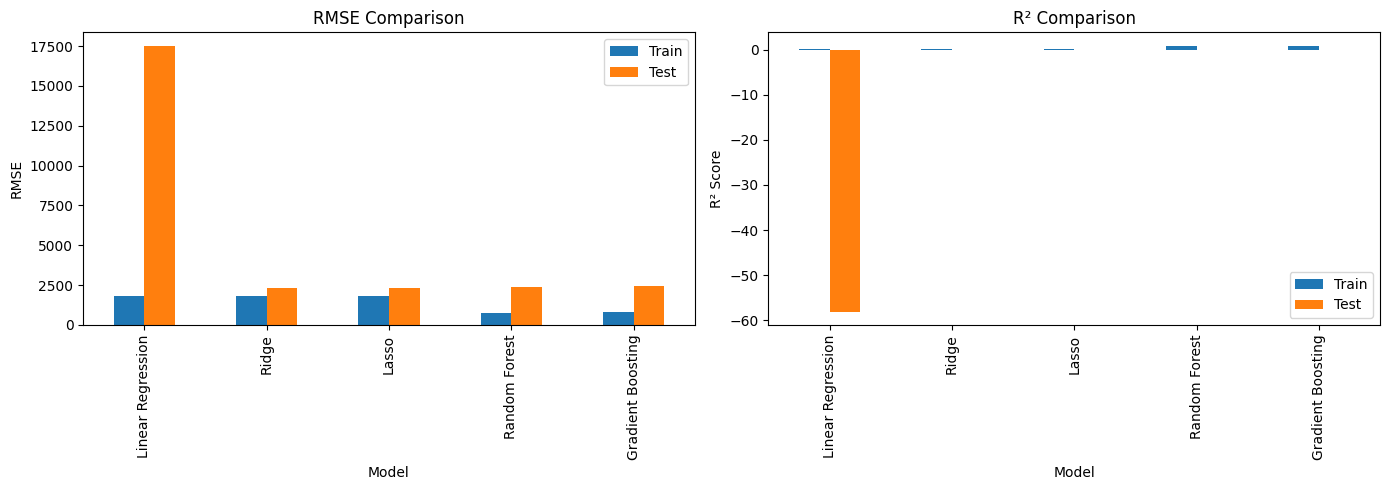

In [ ]:
comparison = pd.DataFrame(
    {
        "Model": list(results.keys()),
        "Train RMSE": [results[m]["train_rmse"] for m in results],
        "Test RMSE": [results[m]["test_rmse"] for m in results],
        "Train R²": [results[m]["train_r2"] for m in results],
        "Test R²": [results[m]["test_r2"] for m in results],
    }
)

print(comparison)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

comparison.plot(x="Model", y=["Train RMSE", "Test RMSE"], kind="bar", ax=axes[0])
axes[0].set_title("RMSE Comparison")
axes[0].set_ylabel("RMSE")
axes[0].legend(["Train", "Test"])

comparison.plot(x="Model", y=["Train R²", "Test R²"], kind="bar", ax=axes[1])
axes[1].set_title("R² Comparison")
axes[1].set_ylabel("R² Score")
axes[1].legend(["Train", "Test"])

plt.tight_layout()
plt.show()

In [18]:
best_model_name = "Ridge"
best_model = results[best_model_name]["model"]

if hasattr(best_model, "feature_importances_"):
    importance = pd.DataFrame(
        {"feature": cols, "importance": best_model.feature_importances_}
    ).sort_values("importance", ascending=False)

    print(f"\nTop 15 Most Important Features ({best_model_name}):")
    print(importance.head(15))

    plt.figure(figsize=(10, 6))
    importance.head(15).plot(x="feature", y="importance", kind="barh")
    plt.title(f"Top 15 Feature Importances - {best_model_name}")
    plt.xlabel("Importance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

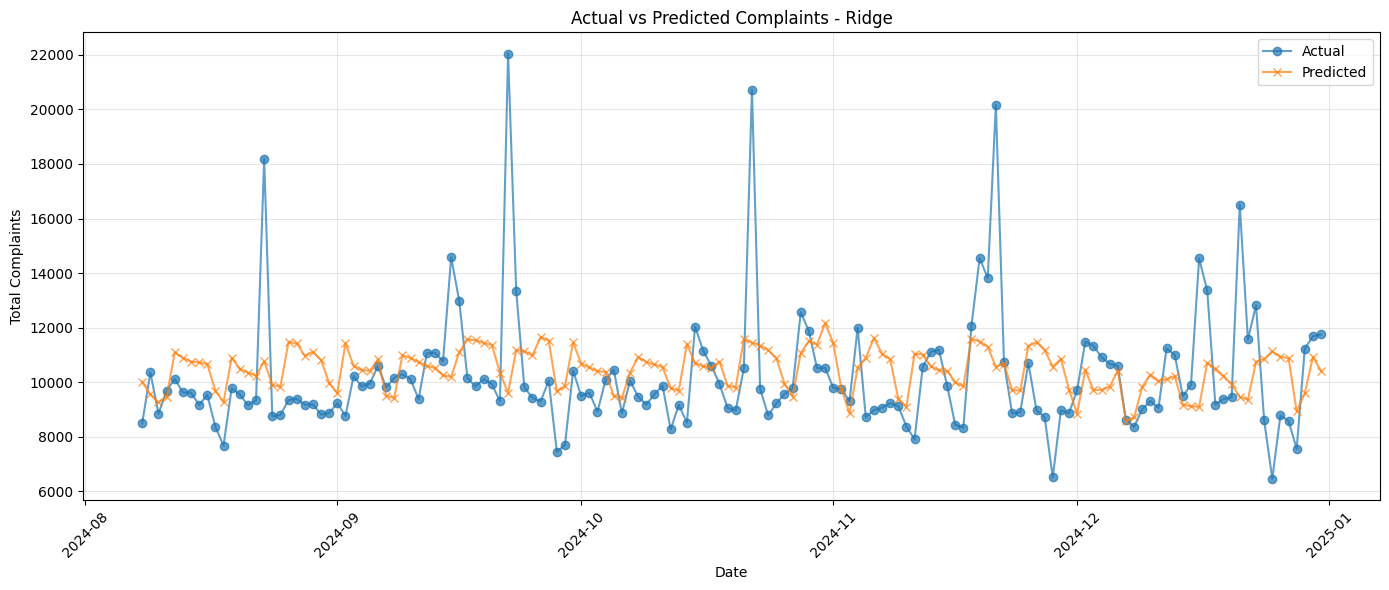

In [19]:
best_predictions = results[best_model_name]["predictions"]

plt.figure(figsize=(14, 6))
test_dates = df_model["date"].iloc[split:].values

plt.plot(test_dates, y_test.values, label="Actual", marker="o", alpha=0.7)
plt.plot(test_dates, best_predictions, label="Predicted", marker="x", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Total Complaints")
plt.title(f"Actual vs Predicted Complaints - {best_model_name}")
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

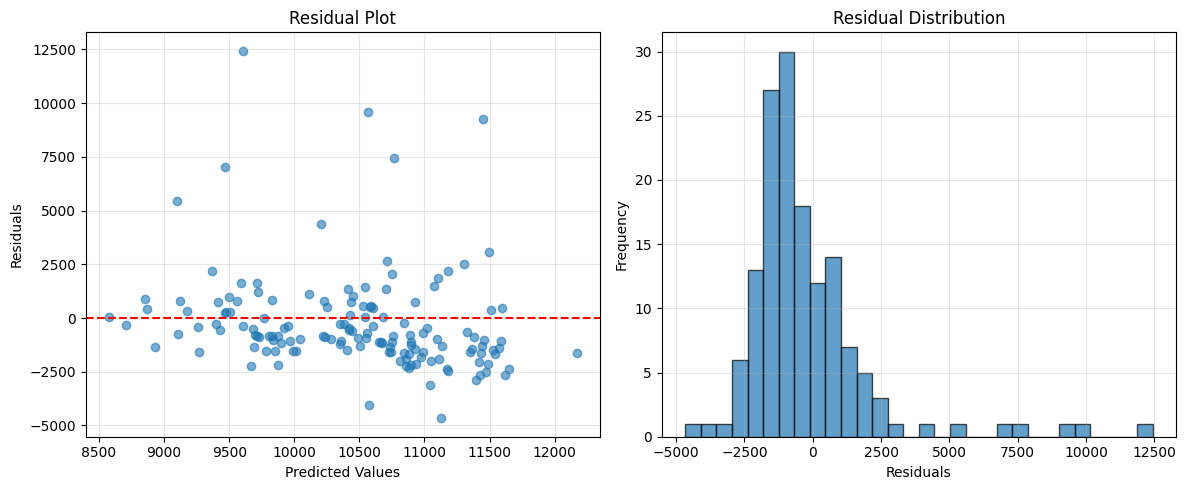

Mean residual: -240.16
Std residual: 2317.03


In [20]:
residuals = y_test.values - best_predictions

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(best_predictions, residuals, alpha=0.6)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean residual: {np.mean(residuals):.2f}")
print(f"Std residual: {np.std(residuals):.2f}")